# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# download files to SageMaker from S3
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

In [3]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:01<00:00, 148MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 38.4kB/s]


In [4]:
# load pickle data into dataframe
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape
#jcap_df.head()
#jcap_df.columns
#jcap_df.bandgap

(100430, 45)

# Define features

In [5]:
def get_bandgap_features(dataframe):
    features = dataframe.drop(['vae','bandgap','spectrum','bandgap_pred'], axis=1, errors='ignore')
    
    return features

# Partition data into seed and candidate data

In [24]:
# Choose every other for train / test
#k_seed_data = jcap_df.iloc[::2]
#k_candidate_data = jcap_df.iloc[1::2]
#k_candidate_data.drop(['bandgap'], axis=1)

# Alternative: choose randomly
k_seed_idx = np.random.rand(len(jcap_df)) < 0.1
k_seed_data = jcap_df[k_seed_idx].copy()
k_candidate_data = jcap_df[~k_seed_idx].copy()
initial_mean_bandgap = np.mean(k_seed_data['bandgap'])

In [25]:
print(len(k_seed_data)/len(k_candidate_data)*100)
print(len(k_seed_data))
print(len(k_candidate_data))

10.886607044275147
9860
90570


In [26]:
k_seed_data = k_seed_data.sort_values('bandgap',ascending=True)
k_seed_data.head(5)

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Ba,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb
comp_id,,,,,,,,,,,,,,,,,,,,,
93084,0.559206,"[-0.0150618795, -0.0017071515, 0.27402103, 0.1...","[0.7138106, 0.72994417, 0.73854434, 0.7410219,...",0.4,0.0,0.0,0.0,0.0,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
93175,0.941860,"[-0.07786628, 0.059474226, 0.36571172, 0.01687...","[0.3493121, 0.35225877, 0.35426617, 0.3555165,...",0.5,0.0,0.0,0.0,0.0,0.1,0.4,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
92927,1.004942,"[-0.02602656, 0.19569442, -0.037329018, -0.131...","[0.4558261, 0.46566707, 0.472643, 0.4771223, 0...",0.0,0.0,0.0,0.0,0.0,0.6,0.3,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
92992,1.033198,"[-0.1801489, 0.21343592, -0.061430767, 0.13143...","[0.5322741, 0.5331009, 0.5328971, 0.5320004, 0...",0.0,0.0,0.0,0.0,0.0,0.3,0.2,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
165077,1.035240,"[0.17601535, 0.05313585, -1.046108, -0.3290466...","[0.39667794, 0.39988044, 0.40322146, 0.4063171...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015,0.0,0.0,0.0,0.0


In [11]:
# test to ensure no overlap between seed and candidate data
assert not set(k_seed_data.index).intersection(k_candidate_data.index)

# Define agent

In [12]:
from camd.agent.base import HypothesisAgent
from sklearn.ensemble import RandomForestRegressor

In [13]:
class RFBandgapAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = get_bandgap_features(seed_data)
        y_known = seed_data['bandgap']
        regressor = RandomForestRegressor(n_estimators=10)
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = get_bandgap_features(candidate_data)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data = candidate_data[candidate_data['bandgap_pred'] > 0.0]
        
        candidate_data = candidate_data.sort_values(
            'bandgap_pred', ascending=True)
        top_candidates = candidate_data.head(1000)
        return top_candidates

In [14]:
bg_agent = RFBandgapAgent()
hypotheses = bg_agent.get_hypotheses(k_candidate_data, k_seed_data)

In [16]:
# see how good the predictions were
hypotheses[['bandgap','bandgap_pred']].head(20)

,bandgap,bandgap_pred
comp_id,,
93165,1.475557,0.634918
92946,0.968794,0.634918
93111,0.930410,0.660155
93108,0.587079,0.660155
93014,1.072708,0.761105
93175,0.941860,0.770700
93075,1.081679,0.810424
93093,1.337550,0.841574
93072,0.681642,0.877576


# Define experiment


In [17]:
from camd.experiment.base import ATFSampler

In [18]:
k_atf_experiment = ATFSampler(dataframe=jcap_df)

In [19]:
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Ba,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb
comp_id,,,,,,,,,,,,,,,,,,,,,
93165,1.475557,"[-0.013845751, 0.007432848, 0.17172433, 0.0284...","[0.49252412, 0.51966673, 0.53859144, 0.5496671...",0.30,0.0,0.0,0.0,0.0,0.0,0.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92946,0.968794,"[-0.111147024, 0.08557887, -0.013162568, 0.020...","[0.6048809, 0.6187588, 0.6269556, 0.6302732, 0...",0.30,0.0,0.0,0.0,0.0,0.1,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93111,0.930410,"[0.005921429, 0.032904185, 0.22380117, 0.04608...","[0.47136092, 0.48600623, 0.4957957, 0.50134623...",0.40,0.0,0.0,0.0,0.0,0.1,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93108,0.587079,"[0.077945046, 0.061617874, 0.2897389, 0.156131...","[0.4935163, 0.49939182, 0.5041059, 0.5076977, ...",0.50,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93014,1.072708,"[0.037240617, 0.16758564, -0.016055644, -0.001...","[0.584416, 0.5953377, 0.6003696, 0.60096157, 0...",0.30,0.0,0.0,0.0,0.0,0.2,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74134,1.502415,"[-0.2995482, -0.18557006, -0.5902399, -0.32689...","[0.18331495, 0.18496194, 0.18630739, 0.1874084...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71746,1.574635,"[-0.063406385, 0.03814801, -0.94686043, -0.053...","[0.14703557, 0.14806399, 0.14904141, 0.1500081...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141849,1.344853,"[-0.97478855, -0.41151553, -1.3776813, -0.2372...","[0.2966677, 0.29623622, 0.29855445, 0.29975486...",0.30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Define analyzer

In [20]:
from camd.analysis import AnalyzerBase

In [38]:
class BandgapAnalyzer(AnalyzerBase):
    
    
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_bandgap = new_experimental_results.bandgap.mean()
        average_dataset_bandgap = new_seed.bandgap.mean()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
            new_experimental_results.index
        ]
        min_new_bandgap = new_experimental_results.bandgap.min()
        min_dataset_bandgap = new_seed.bandgap.min()
        num_new_below_seed_mean_bandgap = sum(i < initial_mean_bandgap for i in new_experimental_results['bandgap'])
        
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_bandgap],
            "average_dataset_bandgap": [average_dataset_bandgap],
            "average_rank": [new_result_ranks.mean()],
            "min_new_bandgap": [min_new_bandgap],
            "min_dataset_bandgap": [min_dataset_bandgap]
        })
        return summary, new_seed

In [41]:
k_analyzer = BandgapAnalyzer()
summary, new_seed = k_analyzer.analyze(results, k_seed_data)

In [42]:
summary

,average_new_bandgap,average_dataset_bandgap,average_rank,min_new_bandgap,min_dataset_bandgap
0,1.443493,2.235,0.072262,0.57456,0.559206


# Define campaign

In [43]:
import os
from monty.os import cd
from camd.campaigns.base import Campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=k_candidate_data, 
        seed_data=k_seed_data,
        agent=bg_agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

Campaign initialization state: Agent RFBandgapAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RFBandgapAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RFBandgapAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RFBandgapAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RFBandgapAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state:

In [44]:
# Pull up some results
history = pd.read_pickle('test/history.pickle')

In [45]:
history

,average_new_bandgap,average_dataset_bandgap,average_rank,min_new_bandgap,min_dataset_bandgap
0,1.460611,2.236577,0.076411,0.574560,0.559206
1,1.553154,2.178952,0.134662,0.730551,0.559206
2,1.643861,2.137343,0.194136,0.877384,0.559206
3,1.742224,2.108836,0.257281,0.704428,0.559206
4,1.784361,2.087000,0.290931,0.735384,0.559206
5,1.835989,2.071174,0.331512,0.896977,0.559206
6,1.851307,2.058133,0.349751,0.006473,0.006473
7,1.887307,2.048568,0.380796,1.004461,0.006473
8,1.930938,2.042331,0.415086,1.076315,0.006473
9,1.971520,2.038766,0.448404,1.130362,0.006473


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a817fd550>,
      dtype=object)

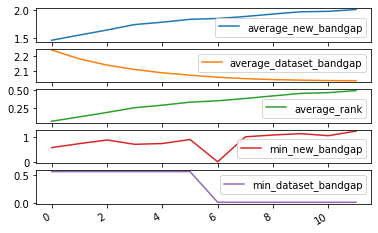

In [46]:
#visualize learning
history.plot(subplots=True)